In [1]:
import cv2
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt

import importlib.metadata

importlib.metadata.version("openvino")


import cv2
import torch
import numpy as np
import pickle
from cap_from_youtube import cap_from_youtube

import tapnet.utils as utils
from tapnet.tapir_inference import OVTapirInference, TapirInference

In [2]:
num_frames = 40

In [3]:
tapir = OVTapirInference("models/tapir_predictor_fp16_p100_n4_480.xml", "models/tapir_encoder_fp16_p100.xml", "GPU")
# tapir_torch = TapirInference("models/causal_bootstapir_checkpoint.pt", (480,480), 4, 100,  "cpu", )

In [4]:
def run_inference(model, video, num_frames):
    if isinstance(model, OVTapirInference):
        input_size = tapir.predictor.inputs[0].shape[-1]
        num_points = tapir.predictor.inputs[3].shape[2]
        num_iters = tapir.predictor.inputs[3].shape[0]
    else:
        input_size = tapir.input_resolution[0]
        num_points = tapir.num_points
        num_iters = tapir.num_iters
    
    query_points = utils.sample_grid_points(input_size, input_size, num_points)
    point_colors = utils.get_colors(num_points)
    
    tracks = np.zeros((num_points, num_frames, 2), dtype=object)
    
    for i, frame in enumerate(video[:num_frames]):
        if i == 0:
            tapir.set_points(frame, query_points)
    
        points, visibles = tapir.forward(frame)
    
        # Record visible points
        tracks = np.roll(tracks, 1, axis=1)
        tracks[visibles, 0] = points[visibles]
        tracks[~visibles, 0] = -1
    
    # Draw the results
    showframe = utils.draw_tracks(frame[:,:,::-1], tracks, point_colors)
    showframe = utils.draw_points(showframe, points, visibles, point_colors)
    return showframe

In [5]:
with open("tapvid_davis/tapvid_davis.pkl", "rb") as f:
    data = pickle.load(f)
video = data["horsejump-high"]["video"]

In [6]:
data.keys()

dict_keys(['goat', 'car-roundabout', 'motocross-jump', 'breakdance', 'drift-chicane', 'drift-straight', 'judo', 'soapbox', 'dogs-jump', 'parkour', 'india', 'pigs', 'cows', 'gold-fish', 'paragliding-launch', 'camel', 'blackswan', 'dog', 'bike-packing', 'shooting', 'lab-coat', 'kite-surf', 'bmx-trees', 'dance-twirl', 'car-shadow', 'libby', 'scooter-black', 'mbike-trick', 'loading', 'horsejump-high'])

In [7]:
models = (tapir,)

result_frames = []
for n, tapir in enumerate(models):
    result_frame = run_inference(tapir, video, num_frames)
    result_frames.append(result_frame)

points (100, 2)


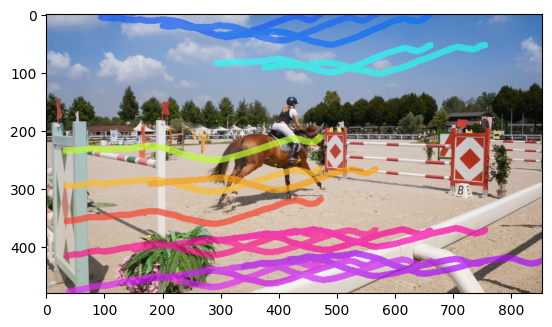

In [8]:
fig, ax = plt.subplots(1, len(result_frames), squeeze=False)
for i, result_frame in enumerate(result_frames):
    ax[0,i].imshow(result_frame[:,:,::-1])